# Data analysis

In [31]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

try:
    sc = SparkContext('local[*]')
    sc.setLogLevel("OFF")
    
except ValueError:
    # Prevent the notebook to crash if this block is executed more then once
    pass

spark = SparkSession(sc)

In [4]:
wifi   = spark.read.parquet("./data/ds/wifi-log.parquet")
gps    = spark.read.parquet("./data/ds/gps-log.parquet")
oui    = spark.read.parquet("./data/ds/oui.parquet")
survey = spark.read.parquet("./data/ds/survey.parquet")

In [5]:
survey.groupBy("date").count().withColumn("day", date_format("date", "EEEE")).toPandas()

,date,count,day
0,2017-12-08,46,Friday
1,2017-12-06,46,Wednesday
2,2017-12-13,33,Wednesday
3,2017-11-29,38,Wednesday
4,2017-12-07,43,Thursday
5,2017-12-11,36,Monday
6,2017-12-12,36,Tuesday


In [6]:
phones = wifi.join(oui.dropDuplicates(["prefix"]), substring("mac", 0, 8) == col("prefix"))
makers = phones.groupBy("maker").count().orderBy(desc("count"))

wifi_total = wifi.count()
phones_total = phones.count()

totals = spark.createDataFrame([
    ("Celulares", phones_total, "%.2f%%" % (phones_total / wifi_total * 100)),
    ("Total",  wifi_total, "100%")
], ["", "count", "P"])
totals.toPandas()

,,count,P
0,Celulares,721846,79.57%
1,Total,907168,100%


In [8]:
to_percentage = lambda col_name, total: format_string("%.2f%%", col(col_name) / total * 100)

makers = makers.withColumn("share", to_percentage("count", phones_total))
makers.toPandas().head(50)

,maker,count,share
0,Samsung,258449,35.80%
1,Motorola,201424,27.90%
2,Lenovo,155135,21.49%
3,LG,47524,6.58%
4,Apple,27201,3.77%
5,Sony,15901,2.20%
6,Microsoft,7087,0.98%
7,Google,2521,0.35%
8,Xiaomi,2322,0.32%
9,Huawei,1147,0.16%


In [9]:
from operator import add

OTHERS_THRESHOLD = 7000

count = makers.filter(col("count") < OTHERS_THRESHOLD).rdd.map(lambda x: x["count"]).reduce(add)
share = "%.2f%%" % (count / phones_total * 100)

others = spark.createDataFrame([("Outros", count, share)], ["maker", "count", "share"])
others.toPandas()

,maker,count,share
0,Outros,9125,1.26%


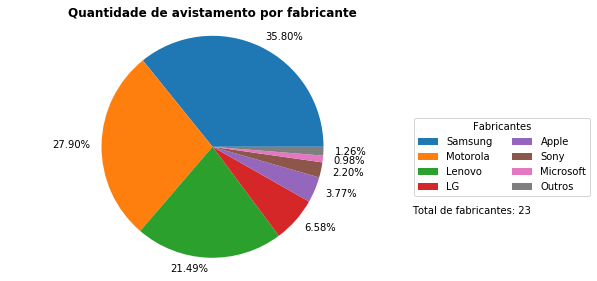

In [10]:
m = makers.filter(col("count") > OTHERS_THRESHOLD).unionAll(others).toPandas()

# 'tab20', 'tab20b', 'tab20c'
# patches.set_cmap("tab20b")

patches, texts = plt.pie(m['count'], labels=m['share'], startangle=0)
plt.title("Quantidade de avistamento por fabricante", {'fontweight':'bold'})
plt.text(1.8, -0.6, "Total de fabricantes: %d" % makers.count())
plt.legend(patches, m['maker'], ncol=2, loc=(1, 0.3), title="Fabricantes")
plt.axis('equal')
plt.tight_layout()

In [11]:
phones_ds = (
    phones
    .withColumn("date", to_date("timestamp"))
    .withColumn("timestamp", to_utc_timestamp(regexp_replace("timestamp", ",", "."), "UTC"))
    .drop("level", "organization", "prefix")
)
phones_ds.groupBy("date").count().withColumn("day", date_format("date", "EEEE")).orderBy("date").toPandas()

,date,count,day
0,2017-11-29,102010,Wednesday
1,2017-12-06,130846,Wednesday
2,2017-12-07,77263,Thursday
3,2017-12-08,156245,Friday
4,2017-12-11,79781,Monday
5,2017-12-12,165903,Tuesday
6,2017-12-13,9798,Wednesday


In [28]:
mins = lambda i: i * (60*60)

IS_PASSENGER_THRESHOLD = 2

sightings_within_5sec = (
    Window.partitionBy("mac")
    .orderBy(col("timestamp").cast("long"))
    .rangeBetween(0, 5)
)

sightings = (
    phones_ds
    .drop("date")
    # 1) Unique MAC sightings within 5 seconds
    .withColumn("fst_sight", first("timestamp").over(sightings_within_5sec))
    .filter(col("fst_sight") == col("timestamp"))
    .drop("fst_sight")
    # 2) Group sightings in a sliding windown of 5 minutes each minute
    .groupBy(window("timestamp", "3 minutes", "1 minute"))
    .agg(collect_list("mac").alias("addresses"))
    .orderBy("window")
    # 3) Filter adresses only sighted few times within the window
    .select("window", explode("addresses").alias("mac"))
    .groupBy("window", "mac").count()
    .filter(col("count") > IS_PASSENGER_THRESHOLD)
    .drop("count")
    # 4) Estimate the occupation
    .groupBy("window").count()
)

# Summary
(
    sightings
    .withColumn("day", date_format("window.start", "EEEE"))
    .withColumn("date", date_format("window.start", "yyyy-MM-dd"))
    .groupBy("date").agg(first("day").alias("day"), sum("count"))
    .toPandas()
)

,date,day,sum(count)
0,2017-12-08,Friday,28277
1,2017-12-11,Monday,14987
2,2017-12-13,Wednesday,2488
3,2017-12-06,Wednesday,23144
4,2017-12-07,Thursday,9797
5,2017-12-12,Tuesday,31415
6,2017-11-29,Wednesday,18105


## Escala de classificação da ocupação de um veículo.

|   | Descrição | Definição |
|---|-----------|-----------|
| 1 | Parcialmente sentados | Alguns lugares vazios |
| 2 | Sentados | Todos os bancos ocupados |
| 3 | 25% de ocupação | Todos os bancos ocupados com algumas pessoas em pé |
| 4 | 50% de ocupação | Meia lotação do corredor |
| 5 | 75% de ocupação | Lotação de 3/4 do veículo |
| 6 | 90% de ocupação | Apesar de lotado, observa-se que tem capacidade para atender mais usuários |
| 7 | Lotado | Capacidade total utilizada |
| 8 | Superlotado | Além da capacidade normal |

In [49]:
MAX_OCCUPATION = 58 + 118

def relativeOccupation(sightings):
    if sightings < 58:
        return 1
    elif sightings >= 58 and sightings < 43:
        return 2
    elif sightings >= 43 and sightings < 88:
        return 3
    elif sightings >= 88 and sightings < 132:
        return 4
    elif sightings >= 132 and sightings < 158:
        return 5
    elif sightings >= 158 and sightings < MAX_OCCUPATION:
        return 6
    elif sightings >= MAX_OCCUPATION and sightings < MAX_OCCUPATION + 10:
        return 7
    else:
        return 8

occ = udf(lambda x: relativeOccupation(x), IntegerType())

occupation = sightings.withColumn("occupation", occ("count"))    

(
    occupation
    .withColumn("day", date_format("window.start", "EEEE"))
    .withColumn("date", date_format("window.start", "yyyy-MM-dd"))
    .groupBy("date")
    .agg(
        first("day").alias("day"), 
        date_format(first("window.start"), "HH:mm:ss").alias("start"), 
        date_format(last("window.end"), "HH:mm:ss").alias("end"),
        avg("occupation")
    )
).toPandas()

,date,day,start,end,avg(occupation)
0,2017-12-08,Friday,19:57:00,22:24:00,6.117241
1,2017-12-11,Monday,08:16:00,10:21:00,4.333333
2,2017-12-13,Wednesday,14:33:00,14:59:00,3.833333
3,2017-12-06,Wednesday,18:49:00,21:26:00,5.077419
4,2017-12-07,Thursday,07:50:00,09:39:00,3.336449
5,2017-12-12,Tuesday,17:25:00,21:41:00,4.279528
6,2017-11-29,Wednesday,05:45:00,09:48:00,2.954357


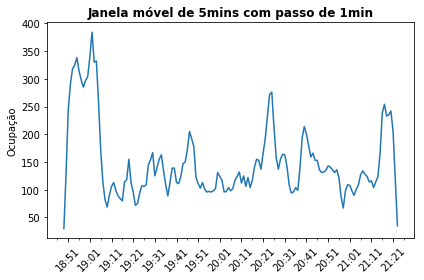

In [13]:
import matplotlib.dates as mdates

r = occupation.toPandas()
r['start'] = r["window"].map(lambda x: x[0])
r = r.set_index('start')

x = np.arange(len(r)) # r["window"].map(lambda x: x[0]).values

fig, ax = plt.subplots()
ax.plot(r.index, r['occupation'])

ax.set_ylabel("Ocupação")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.title("Janela móvel de 5mins com passo de 1min", {'fontweight': 'demi'})
plt.xticks(rotation=45)
plt.tight_layout()